In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Training

base_dir = '/content/drive/MyDrive/Pose Estimation/data/Taken'

# Function to retrieve all image paths from a directory
def get_image_paths(directory):
    # List to store paths
    image_paths = []
    # os.walk goes through all subdirectories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            # Check for jpeg files
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                # Construct full file path
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
    return image_paths

# Get image paths for 'sweep' and 'pull' directories
sweep_images = get_image_paths(os.path.join(base_dir, 'sweep'))
pull_images = get_image_paths(os.path.join(base_dir, 'pull'))

# Combine all image paths
all_image_paths = sweep_images + pull_images

images_to_remove = ['5.jpeg', '3pull.jpeg']

# Filter out specific images
filtered_image_paths = [path for path in all_image_paths if not any(img in path for img in images_to_remove)]



In [ ]:
# Training 2

base_dir2 = '/content/drive/MyDrive/Pose Estimation/data/Manual'

# Function to retrieve all image paths from a directory
def get_image_paths(directory):
    # List to store paths
    image_paths = []
    # os.walk goes through all subdirectories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            # Check for jpeg files
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                # Construct full file path
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
    return image_paths

# Get image paths for 'sweep' and 'pull' directories
sweep_images_t = get_image_paths(os.path.join(base_dir2, 'Sweep'))
pull_images_t = get_image_paths(os.path.join(base_dir2, 'Pull'))

# Combine all image paths
all_image_paths_t = sweep_images_t + pull_images_t


In [ ]:
#Testing

base_dir3 = '/content/drive/MyDrive/Pose Estimation/data/Test'

v_image_paths = []

# Walk through the directory
for root, dirs, files in os.walk(base_dir3):
    for file in files:
        # Check for specific file extensions if needed (e.g., '.jpg', '.png')
        if file.endswith(".jpg") or file.endswith(".jpeg"):
            # Construct the full path to the file
            path = os.path.join(root, file)
            v_image_paths.append(path)

# Now image_paths contains all the paths to the images in your validation dataset
print(v_image_paths)


['/content/drive/MyDrive/Pose Estimation/data/Test/WhatsApp Image 2024-04-22 at 11.15.19 AM.jpeg']


In [ ]:
model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = model.signatures['serving_default']

In [ ]:
image_path= '/content/drive/MyDrive/Pose Estimation/data/Taken/pull/6pull.jpeg'

In [ ]:
# Draw too

def draw_pose(image, keypoints):
    # Define the connections between keypoints to form a pose
    connections = [
        [0, 1], [0, 2], [1, 3], [2, 4],  # Upper body
        [5, 6], [5, 7], [7, 9], [6, 8],  # Lower body
        [8, 10], [5, 11], [6, 12], [11, 12],  # Arms
        [11, 13], [12, 14], [13, 15], [14, 16]  # Forearms
    ]

    # Convert image from float to uint8
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.squeeze(image)  # Remove batch dimension

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    height, width = image.shape[:2]

    # Plot keypoints
    for keypoint in keypoints[0][0]:
        y, x, confidence = keypoint
        if confidence > 0.1:  #
            plt.plot(x * width, y * height, 'ro', markersize=5)

    # Connect keypoints to visualize the pose
    for connection in connections:
        start_keypoint = keypoints[0][0][connection[0]]
        end_keypoint = keypoints[0][0][connection[1]]
        start_point = (start_keypoint[1] * width, start_keypoint[0] * height)  # Flip x and y
        end_point = (end_keypoint[1] * width, end_keypoint[0] * height)  # Flip x and y
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'g-', linewidth=2)

    plt.axis('off')
    plt.show()

def run_pose_estimation(image_path):
    # Load and prepare the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float values in [0, 1]

    # Resize the image to match the expected input size of MoveNet
    img = tf.image.resize(img, (192, 192))

    # Convert the image to int32 data type
    img = tf.cast(img * 255, dtype=tf.int32)

    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)

    # Run model inference
    results = movenet(input=img)  # Pass the image as 'input' argument
    keypoints = results['output_0'].numpy()


    # Draw pose on the image
    draw_pose(img, keypoints)


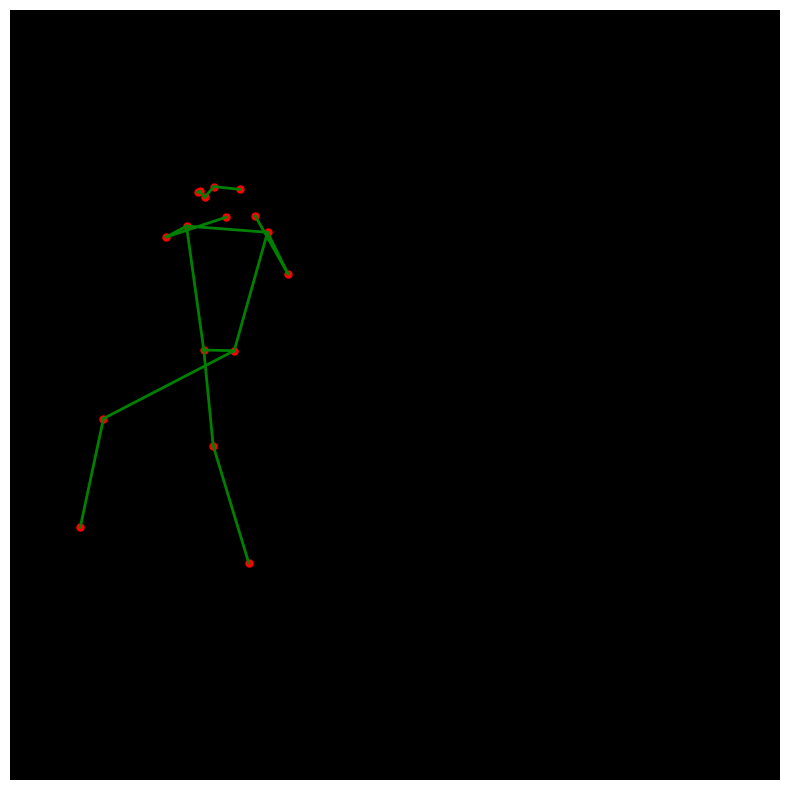

In [ ]:
run_pose_estimation(image_path)

In [ ]:
# Let's do classification:

In [ ]:
test_paths=['/content/drive/MyDrive/Pose Estimation/data/Taken/sweep/1.jpeg']

In [ ]:
# Load the MoveNet "lightning" model from TensorFlow Hub
model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = model.signatures['serving_default']

# Function to extract keypoints from an image
def extract_keypoints(image_path):
    # Load and prepare the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float values in [0, 1]

    # Resize the image to match the expected input size of MoveNet
    img = tf.image.resize(img, (192, 192))

    # Convert the image to int32 data type
    img = tf.cast(img * 255, dtype=tf.int32)

    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)

    # Run model inference
    results = movenet(input=img)  # Pass the image as 'input' argument
    keypoints = results['output_0'].numpy()

    # Flatten the keypoints array
    keypoints_flat = keypoints.flatten()

    return keypoints_flat

image_paths_pull = pull_images_t + pull_images
image_paths_sweep = sweep_images_t + sweep_images


# Extract keypoints from labeled images
X_pull = np.array([extract_keypoints(image_path) for image_path in image_paths_pull])
X_sweep = np.array([extract_keypoints(image_path) for image_path in image_paths_sweep])

# Create labels for pull shots (class 0) and sweep shots (class 1)
y_pull = np.zeros(len(X_pull))
y_sweep = np.ones(len(X_sweep))

# Concatenate feature matrices and labels
X = np.concatenate((X_pull, X_sweep), axis=0)
y = np.concatenate((y_pull, y_sweep), axis=0)

X_train = np.concatenate((X_pull, X_sweep), axis=0)
y_train = np.concatenate((y_pull, y_sweep), axis=0)

# Train classifier
#model = LogisticRegression()
#model = RandomForestClassifier(n_estimators=500, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#model = LinearSVC(C=1.0, max_iter=10000)
#model = MLPClassifier(tol=1e-6,activation='relu',hidden_layer_sizes=(30,4), max_iter=10000, alpha=1e-4,solver='sgd', verbose=10, random_state=1,learning_rate_init=.1)
model.fit(X_train, y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

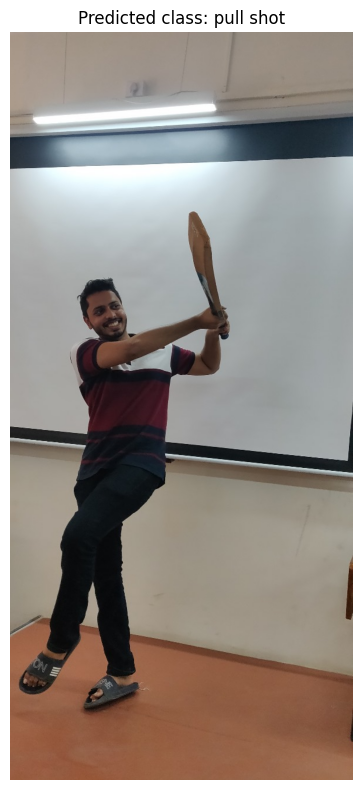

In [ ]:
# Load test data

X_test = np.array([extract_keypoints(image_path) for image_path in v_image_paths])

# Predict on test data
y_pred = model.predict(X_test)

plt.figure(figsize=(4, 8))
for i, (image_path, prediction) in enumerate(zip(v_image_paths, y_pred)):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Plot image
    plt.subplot(len(v_image_paths), 1, i + 1)
    plt.imshow(image)
    plt.title(f"Predicted class: {'pull shot' if prediction == 0 else 'sweep shot'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("Predictions for test images:")
for image_path, prediction in zip(v_image_paths, y_pred):
    print(f"Image: {image_path}, Predicted class: {'pull shot' if prediction == 0 else 'sweep shot'}")